In [1]:
import argparse
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils

from tqdm import tqdm

from vqvae import VQVAE
from scheduler import CycleScheduler

In [2]:
# grab the names of the pre-processed video files
video_filenames_proc = glob.glob('/home/jarrod/dev/speech-driven-animation/data/aligned_faces/*.npy')

# delete bad entries
bad_files = ['bgit2n', 'lbij7a', 'lrbr3s', 'pbio7a', 'sbaa4p', 'sgwp8p', 'sbim8p', 
             'srwi5a', 'swao7a', 'srbb4n', 'sbbbzp', 'lrae3s']

for i,f in enumerate(video_filenames_proc):
    
    for bad in bad_files:
        if f.find(bad) != -1:
            del video_filenames_proc[i]
            break

In [3]:
class getDataSample():
    def __init__(self, gpu=1):

        self.audio_path = '/home/jarrod/dev/speech-driven-animation/data/npy_audio/'
        self.device = torch.device("cuda:" + str(gpu))

        self.mean_face = np.load('/home/jarrod/dev/speech-driven-animation/data/mean_face.npy')
        self.img_size = (128,128)
        self.aux_latent = 10
        self.sequential_noise = True
    
        rnn_gen_dim = 256
        id_enc_dim = 128
        aud_enc_dim = 256
        audio_feat_len = 0.2
        self.audio_rate = 50000
        self.video_rate = 25
        self.audio_feat_samples = 10000
        self.conversion_dict = {'s16': np.int16, 's32': np.int32}
        
        # image preprocessing
        self.img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.img_size[0], self.img_size[1])),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


    def preprocess_img(self, img):
        src = self.fa.get_landmarks(img)[0][self.stablePntsIDs, :]
        dst = self.mean_face[self.stablePntsIDs, :]
        tform = tf.estimate_transform('similarity', src, dst)  # find the transformation matrix
        warped = tf.warp(img, inverse_map=tform.inverse, output_shape=self.img_size)  # wrap the frame image
        warped = warped * 255  # note output from wrap is double image (value range [0,1])
        warped = warped.astype('uint8')

        return warped

    def __call__(self, filename, num_d1_samples, fs=None, aligned=False):
        
        audio_filename = self.audio_path + filename.split('/')[-1].split('.npy')[0] + '.wav.npy'
        
       
    
        vid_data = np.load(filename)
        frame = np.copy(vid_data[0])
                
        # take the input image and preprocess it    
        frame = self.img_transform(frame)
            
        frame = frame.unsqueeze(0)
        
        # Load preprocessed audio data
        audio_feat_seq = np.load(audio_filename)
        
        audio_feat_seq = torch.Tensor(audio_feat_seq)
        audio_feat_seq_length = audio_feat_seq.shape[1]
                
        samp = np.random.rand(num_d1_samples)*audio_feat_seq_length
        samp = samp.astype(int)

        
        normed_vid_data = []
        
        for i, img in enumerate(vid_data):
            normed_vid_data.append((self.img_transform(img)+ 1.0) / 2.0)
        
        normed_vid_data = torch.stack(normed_vid_data)
        
#         d1_frames = normed_vid_data[samp]

        # shuffle the id frames, otherwise the discriminator learns too fast    
#         np.random.shuffle(samp)
#         d1_frames_shuff = normed_vid_data[samp]

#         frame_c = frame.repeat(num_d1_samples,1,1,1) 
        # concat the id_frame onto the back of axis 1 (indices 3:)
#         d1_frames = torch.cat((d1_frames, d1_frames_shuff), axis=1)
        
        
        return audio_feat_seq, audio_feat_seq_length, frame, normed_vid_data

In [4]:
va = getDataSample()
aud, _, _, vid  = va(video_filenames_proc[0], 10, aligned=True)

In [27]:
test = vid.permute(0,2,3,1)

In [28]:
test.shape

torch.Size([75, 128, 128, 3])

In [7]:
for i, filename in enumerate(video_filenames_proc):

    aud, _, _, vid  = va(filename, 10, aligned=True)
    aud = aud.permute(1,0,2,3)
    vid = vid.permute(0,2,3,1)
    
    
    if i % 50 == 0:
        print(i)
    
    if aud.shape[0] == vid.shape[0]:
    
        for j, frame in enumerate(vid):
            
            if j == 0:
                np.save('/home/jarrod/dev/vq-vae-2-pytorch/vid_test_data/'+filename.split('faces/')[1].split('.')[0]+'_vid_' + str(j) + '_id', vid[j])
                np.save('/home/jarrod/dev/vq-vae-2-pytorch/vid_test_data/'+filename.split('faces/')[1].split('.')[0]+'_aud_' + str(j) + '_id', aud[j])
                
            else:
            
                np.save('/home/jarrod/dev/vq-vae-2-pytorch/vid_test_data/'+filename.split('faces/')[1].split('.')[0]+'_vid_' + str(j), vid[j])
                np.save('/home/jarrod/dev/vq-vae-2-pytorch/vid_test_data/'+filename.split('faces/')[1].split('.')[0]+'_aud_' + str(j), aud[j])
            
    

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950


In [30]:
test = np.load('/home/jarrod/dev/vq-vae-2-pytorch/vid_test_data/swwv9a_vid_9.npy')

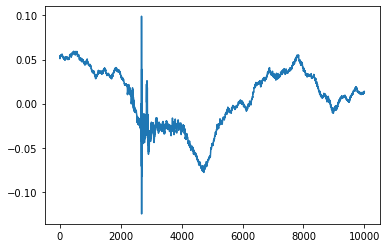

In [33]:
plt.plot(test[0])